In [44]:
# default_exp core

# simple_interpolation

> Interpolation rocks, but it can screw the original features of your data series if done poorly. One algorithm that at least preserves the original volatility is **Brownian Bridge**, which uses it as an input. This is an implementation of the Brownian Bridge to be used with **Pandas**.

In [45]:
#hide
from nbdev.showdoc import *

In [58]:
#export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import is_datetime64_any_dtype as is_datetime

In [47]:
#export
def interpolate_gaps(df_to_patch, method = 'wiener', fixed_freq = 'min', plot = False):
    """
    Searches for gaps and interpolates with a Brownian Bridge,
    which preserves volatility of the whole trend.

    ::returns:: patched, interpolated DataFrame with 3 columns:
                    "X_original_name", 
                    "Y_original_name",
                    "interpolated" (flag to mark interpolated rows)
    """

    # Check DataFrame is well formated and identifies X,Y columns
    dataframe_valid, params_deduced = check_dataframe(df_to_patch)  
    if dataframe_valid:
        x_column = params_deduced['x_column']
        y_column = params_deduced['y_column']
        datetime_present = params_deduced['datetime_flag']
    else:
        raise Exception(f'DataFrame did not pass the check_dataframe() tests. Check previous logs')
    
    # std generation method validation
    if method == 'wiener':
        print("std() built with Wiener method")
    elif method == 'local_scan':
        print("std() built with local_scan method")
    else:
        raise Exception(f"ERROR: 'method' argument must be 'wiener' (default) or 'local_scan', but got {method}")  
    
    # Detecting gaps and labeling them

    # Reset index (we need a continous one for this algorithm! Otherwise .iloc[] can go crazy)
    df_to_patch = df_to_patch.reset_index().drop(columns=['index'])
    
    # Fast way to calculate deltas: adding shifted column, so we calculate delta on same row (fast)
    # global df_shift
    df_shift = df_to_patch.copy()
    df_shift[x_column + '_shift'] = df_shift[x_column].shift(1)
    df_shift['x_deltas'] =  df_shift[x_column] - df_shift[x_column + '_shift']
    expected_gap = df_shift['x_deltas'].mean()
    # gap_deviation = df_shift['x_deltas'].std()
    
    # Add column with "gap?" flags
    if datetime_present:
        interval = expected_gap.total_seconds()*1.01 # maybe turn this into a parameter ("sensibility"?)
        params_deduced['interval'] = interval
        df_shift['gap?'] = df_shift['x_deltas'].apply(lambda x: 1 if x.total_seconds() > interval else 0)
    else:
        interval = expected_gap*1.01 # maybe turn this into a parameter ("sensibility"?)
        params_deduced['interval'] = interval
        df_shift['gap?'] = df_shift['x_deltas'].apply(lambda x: 1 if x > interval else 0)
    
    # Gap indexes to attack
    gap_indexes = df_shift.index[df_shift['gap?'] == 1].tolist()

    # Print interval threshold (so user can see if it looks good)
    print(f"Will interpolate if X-column interval is more than {interval}")

    # Patch collection
    patch_collection = []
    
    for gap_index in gap_indexes:    
        # Loadbar
        if gap_indexes.index(gap_index) % 50 == 0:
            perc = (gap_indexes.index(gap_index) / len(gap_indexes))*100
            print(f"Processed "+"{:.2f}".format(perc) + "% of gaps")

        # Relevant rows
        current_row = df_to_patch.iloc[gap_index]
        previous_row = df_to_patch.iloc[gap_index - 1]
        delta = current_row[x_column] - previous_row[x_column]
        if datetime_present:
            delta_in_float = delta.total_seconds()
        else:
            delta_in_float = delta
        
         # If finds gap
        if delta_in_float > interval:
            # Interpolate
            interpolated = []
            x0, y0 = previous_row[x_column], previous_row[y_column]
            x1, y1 = current_row[x_column], current_row[y_column]
            local_std = get_local_std(delta, df_to_patch, params_deduced, gap_index, method = method)
            local_variance = local_std * local_std
            bb(x0, y0, x1, y1, params_deduced, local_variance, interpolated, fixed_freq)

            # From list of tuples to df
            inter_df = pd.DataFrame(interpolated, columns = [x_column, y_column])
            inter_df = inter_df.sort_values(by=[x_column])
            inter_df['interpolated'] = 1            

            # Add to patch collection
            patch_collection.append(inter_df)
            
    # Patch original, re-sort on X-column, drop old index
    df_to_patch['interpolated'] = 0
    patched = df_to_patch
    for patch in patch_collection:
        patched = pd.concat([patched, patch])
    patched = patched.sort_values(by=[x_column])
    patched = patched.reset_index().drop(columns=['index'])

    # Plotting results if asked for it
    if plot:
        print("Ended interpolation, starting plotting the results..")
        plot_results(patched)
    else:
        print("Ended succesfully")
   
    print("Ended execution")
    return patched

In [55]:
# hide
x = list(range(0,50))
y = [np.random.normal(loc = 10.0, scale = 1.5) for _ in x]

# Delete some points
points_to_remove = [3,4,5,17,18]
points_to_remove.extend(list(range(29,45)))
# points_to_remove.extend(list(range(55,60)))
# points_to_remove.extend(list(range(70,95)))
for removal in points_to_remove:
    i = x.index(removal)
    x.remove(removal)
    y.remove(y[i])
    
df = pd.DataFrame(list(zip(x, y)), 
               columns =['X', 'Y']) 

In [56]:
# Example dataframe
df

,X,Y
0,0,11.844657
1,1,9.800014
2,2,7.690769
3,6,9.601032
4,7,9.723581
5,8,11.044739
6,9,10.988900
7,10,9.685440
8,11,9.287421
9,12,10.877917


No datetime column: assuming first column 'X' as X-axis
std() built with Wiener method
Will interpolate if X-column interval is more than 1.7675
Processed 0.00% of gaps
Ended interpolation, starting plotting the results..


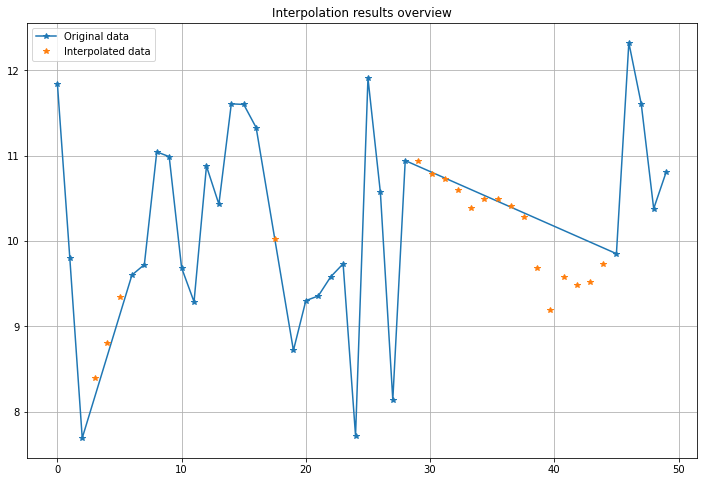

Ended execution


,X,Y,interpolated
0,0.0000,11.844657,0
1,1.0000,9.800014,0
2,2.0000,7.690769,0
3,3.0000,8.390856,1
4,4.0000,8.801952,1
5,5.0000,9.339115,1
6,6.0000,9.601032,0
7,7.0000,9.723581,0
8,8.0000,11.044739,0
9,9.0000,10.988900,0


In [60]:
# Interpolation
patched_df = interpolate_gaps( df , plot = True )
patched_df

In [51]:
#export
def check_dataframe(df):
    """
    Collection of tests done first on the dataframe
    to ensure it's properly formatted for interpolation,
    and identification of x, y columns to be used.
    
    Checks:
    - 2 columns only (or 1 + datetime index)
    - looks for datetime presence (affects the next steps)

    :returns: params_deduced = (
                dataframe_valid :: boolean,
                params_deduced :: dict, stores flags and X,Y colums names 
                )
    """
    # 2 columns
    assert len(df.columns) == 2, f"ERROR: columns are not 2, but {len(df.columns)}! Provide only two columns for interpolation"
    
    # X, Y column check
    # Flag informing of the presence of a datetime
    datetime_present = False
    for column in df.columns:
        datetime_present = is_datetime(df[column])
        if datetime_present:
            print(f"Datetime column detected: assuming '{column}' as X-axis")
            x_column = column
            break    
        else:
            # Detecting whether index is a datetime and turn it into a column 
            # (datetime indexes work differently if shifted(), so let's use same thing)
            datetime_present = isinstance(df.index, pd.DatetimeIndex)
            if datetime_present:
                df['datetime_index_to_column'] = df.index
                x_column = 'datetime_index_to_column'
    # If no datetime, use first column as X
    if datetime_present == False:
        print(f"No datetime column: assuming first column '{df.columns[0]}' as X-axis")
        x_column = df.columns[0]
        
    # y_column
    y_columns = list(df.columns)
    y_columns.remove(x_column)
    y_column = y_columns[0]
    
    params_deduced = {
        'x_column' : x_column,
        'y_column' : y_column,
        'datetime_flag' : datetime_present
    }
    
    dataframe_valid = True
    return dataframe_valid, params_deduced

In [52]:
#export
def plot_results(patched):
    """
    Plot the original series and the interpolated data.
    """
    interpolated = patched.where(patched.interpolated==1).dropna()
    original_data = patched.where(patched.interpolated == 0).dropna()
    fig, ax = plt.subplots(figsize = (12,8))

    ax.plot(original_data[patched.columns[0]], original_data[patched.columns[1]], '-*', label = 'Original data')
    ax.plot(interpolated[patched.columns[0]], interpolated[patched.columns[1]], '*', label = 'Interpolated data')

    ax.legend()
    ax.grid()
    ax.set(title=f'Interpolation results overview')
    plt.show()


In [53]:
#export
def bb(x0, y0, x1, y1, params_deduced, variance, interpolated, fixed_freq):
    """
    Brownian Bridge algo implementation.
    
    - The hard part (calculating the std() to be used) is not done here.   
   
    - If datetime_present = True, we round x_midpoint to ensure 'fixed_freq' timesteps, 
    which defaults to 'min'. Valid options from Pandas, see link:
    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
    
    ::returns:: nothing, but adds (xm, ym) tuples to an interpolated list.
    """
    # Unpack parameters
    # x_column = params_deduced['x_column']
    # y_column = params_deduced['y_column']
    datetime_present = params_deduced['datetime_flag']
    interval = params_deduced['interval']
    
    # If already interval separation, stop
    if datetime_present:
        if (x1 - x0).total_seconds() < interval:
            return
    else:
        if (x1 - x0) < interval:
            return
    
    # Interpolate xm
    xm = x0+(x1-x0)/2
    if datetime_present:
        xm = xm.round(fixed_freq)
        whole_timedelta = (x1 - x0).total_seconds()/interval # In mins
        timedelta_after_round = (xm - x0).total_seconds()/interval
        # deviation from the perfect half-of-interval
        delta_x_from_mid_point = 0.5 - timedelta_after_round / whole_timedelta
        # resultant deviation for Y (not same as X, depends on derivative)
        delta_y_from_mid_point = delta_x_from_mid_point * ((y1-y0)/(x1-x0).total_seconds())
    else:
        delta_y_from_mid_point = 0
    
    # Interpolate ym
    ym = (y0 + y1)/2 + delta_y_from_mid_point
    std = np.sqrt(variance)
    delta = np.random.normal(loc=0.0, scale = std, size = None)
    ym += delta

    # Store interpolation
    interpolated.append((xm, ym))
    
    # Recursion parameters
    """
    husrtExponent: When H is 1/2 (divide by 2 at each level) the standard deviation 
    is constant throughout the curve: in this situation, 
    the curve is a Brownian bridge.
    """
    hurstExponent = 0.5 # see docstring
    scaleFactor = 2 ** (2.0 * hurstExponent)
    
    # Interpolate recursively on left hand side
    bb(x0, y0, xm, ym, params_deduced, variance/scaleFactor, interpolated, fixed_freq)
    
    # Interpolate recursively on right hand side
    bb(xm, ym, x1, y1, params_deduced, variance/scaleFactor, interpolated, fixed_freq)


In [54]:
#export
def get_local_std(delta, df_to_patch, params_deduced, gap_index, method = 'wiener'):
    """
    Calculates variance to be ussed in the interpolation. Must
    be different depending on the gap length.

    Two methods: local_scan and weiner. 'local_scan' is a naive
    approach mostly kept for learning purposes; weiner is default
    and is always recommended.
    
    Assuming a Wiener process (like in stock market theory)
    then std ~ sqrt(delta_t), and in the gap case
    delta_t := delta_t_gap, so:

        std_gap = std_whole / sqrt( delta_t_gap )

    ::returns:: std, float to be used in the brownian bridge
    """
    # Unpack previous df parameters
    x_column = params_deduced['x_column']
    y_column = params_deduced['y_column']
    datetime_present = params_deduced['datetime_flag']
    interval = params_deduced['interval']
    
    # Parse std() method
    if method == 'wiener':
        
        # Estimated points
        if datetime_present:
            estimated_points_to_fill = int(delta.total_seconds()/interval) - 1
        else:
            estimated_points_to_fill = int(delta/interval) - 1
        
        # Weiner process assumed (1D-random-walk analog)
        std_whole = df_to_patch[y_column].std()

        # X-range covered by df
        x_range = df_to_patch[x_column].max() - df_to_patch[x_column].min()
        if datetime_present:
            x_range = x_range.total_seconds()/interval
        else:
            x_range = x_range/interval

        # minute-like std_deviation (Weiner processes verify,
        #  in case of year: std_day = std_year / np.sqrt(365))
        std_point = std_whole / np.sqrt(x_range)
        std_point

        # gap:
        std = std_point * np.sqrt(estimated_points_to_fill)
        
    elif method == 'local_scan':
        scan_area_per_point_in_gap = 30 # or 50 (parameter, hardcoded)

        # Get local std()
        if datetime_present:
            estimated_points_to_fill = int(delta.total_seconds()/interval)
        else:
            estimated_points_to_fill = int(delta/interval)
        local_area_for_std = estimated_points_to_fill * scan_area_per_point_in_gap
        backward_points = int(local_area_for_std / 2)
        forward_points = int(local_area_for_std / 2)

        # In case the backward points are not sufficient (close to beginning of df)
        if gap_index - backward_points < 0:
            backward_index = 0
            # We offset to forward
            forward_index = gap_index + forward_points + abs(gap_index - backward_points)
        else:
            backward_index = gap_index - backward_points
            forward_index = gap_index + forward_points

        # Same for df ending overflow
        if forward_index > len(df_to_patch):
            forward_index = len(df_to_patch)

        std = df_to_patch[y_column].iloc[backward_index:forward_index].std()
        
    else:
        print(f"ERROR: 'method' argument must be 'wiener' (default) or 'local_scan', but got {method}")
        return
   
    return std